In [2]:
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

width of 13,314 pixels and a height of 6,081 pixels.

In [3]:
# Open the raster file
file_path = "amerob/amerob_abundance_median_2022-09-06.tif"
with rasterio.open(file_path) as src:
    # Reproject to WGS84
    dst_crs = 'EPSG:4326'  # WGS84
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('reprojected.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


with rasterio.open('reprojected.tif') as dataset:
    data = dataset.read(1) 
    transform_affine = dataset.transform 

    # Get the coordinates of each pixel
    rows, cols = np.indices(data.shape)
    xs = transform_affine[2] + cols * transform_affine[0] + rows * transform_affine[1]
    ys = transform_affine[5] + cols * transform_affine[3] + rows * transform_affine[4]
    
    # Flatten the arrays
    xs = xs.flatten()
    ys = ys.flatten()
    values = data.flatten()

    # Create a DataFrame
    df = pd.DataFrame({
        'longitude': xs,
        'latitude': ys,
        'value': values
    })
df

,longitude,latitude,value
0,-180.000000,90.000000,NaN
1,-179.973355,90.000000,NaN
2,-179.946710,90.000000,NaN
3,-179.920065,90.000000,NaN
4,-179.893420,90.000000,NaN
...,...,...,...
76066925,179.866775,-59.984462,NaN
76066926,179.893420,-59.984462,NaN
76066927,179.920065,-59.984462,NaN
76066928,179.946710,-59.984462,NaN


Filter the DataFrame based on the specified latitude and longitude range <br>
Replace NaN values with 0. <br>
Convert to Integer <br>
Clip values above 7

In [4]:
filtered_df = df[
    (df['latitude'] >= 24.75) & (df['latitude'] <= 49.25) &
    (df['longitude'] >= -124.75) & (df['longitude'] <= -67.25)
]
amerob = filtered_df.fillna(0).pivot_table(index='latitude', columns='longitude', values='value', aggfunc='mean')
amerob = np.floor(amerob).astype(int)
amerob = amerob.clip(upper=7)
amerob

longitude,-124.738361,-124.711716,-124.685071,-124.658426,-124.631782,-124.605137,-124.578492,-124.551847,-124.525202,-124.498557,...,-67.504996,-67.478351,-67.451706,-67.425061,-67.398416,-67.371771,-67.345126,-67.318481,-67.291836,-67.265191
latitude,,,,,,,,,,,,,,,,,,,,,
24.773146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.799790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.826435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.853080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.879725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49.126636,3,2,2,2,2,2,3,2,2,2,...,0,0,0,0,0,0,0,0,0,0
49.153281,2,2,3,3,3,2,3,2,2,2,...,0,0,0,0,0,0,0,0,0,0
49.179926,2,3,3,3,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0


Convert coordinate indices to normal integer indeces for use in gird indexing

In [5]:
# Resetting the index to replace lat/lon with normal integer index
amerob = amerob.reset_index(drop=True)

# Rename columns to integer indices
amerob.columns = range(amerob.shape[1])

amerob

,0,1,2,3,4,5,6,7,8,9,...,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,3,2,2,2,2,2,3,2,2,2,...,0,0,0,0,0,0,0,0,0,0
915,2,2,3,3,3,2,3,2,2,2,...,0,0,0,0,0,0,0,0,0,0
916,2,3,3,3,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
917,2,2,2,2,2,2,2,2,2,3,...,0,0,0,0,0,0,0,0,0,0


Scale up dimensions by: From '919 rows × 2158 columns' To '392 rows × 920 columns' <br>
Scale population by scale_populataion = NaN

In [48]:
data = amerob.to_numpy()
rescaled_data = scipy.ndimage.zoom(data, (98 / data.shape[0], 230 / data.shape[1]), order=1)
amerob_rescaled = pd.DataFrame(rescaled_data)

scale_factor = 4
data = amerob_rescaled.values
expanded_array = np.zeros((data.shape[0] * scale_factor, data.shape[1] * scale_factor))
expanded_array[::scale_factor, ::scale_factor] = data
new_index = np.linspace(amerob_rescaled.index.min(), amerob_rescaled.index.max(), expanded_array.shape[0])
new_columns = np.linspace(amerob_rescaled.columns.min(), amerob_rescaled.columns.max(), expanded_array.shape[1])
amerob_rescaled = pd.DataFrame(expanded_array)

amerob_rescaled.to_parquet('amerob_2022-09-06.parquet')
print(amerob_rescaled.sum().sum())
amerob_rescaled


15296.0


,0,1,2,3,4,5,6,7,8,9,...,910,911,912,913,914,915,916,917,918,919
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Grid Distribution

In [44]:
value_counts = amerob_rescaled.apply(pd.Series.value_counts).sum(axis=1).fillna(0).astype(int)
distribution_df = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts.values})
distribution_df


,Value,Count
0,0,352487
1,1,4174
2,2,2208
3,3,993
4,4,439
5,5,156
6,6,90
7,7,93


The largest number in the data is: 7


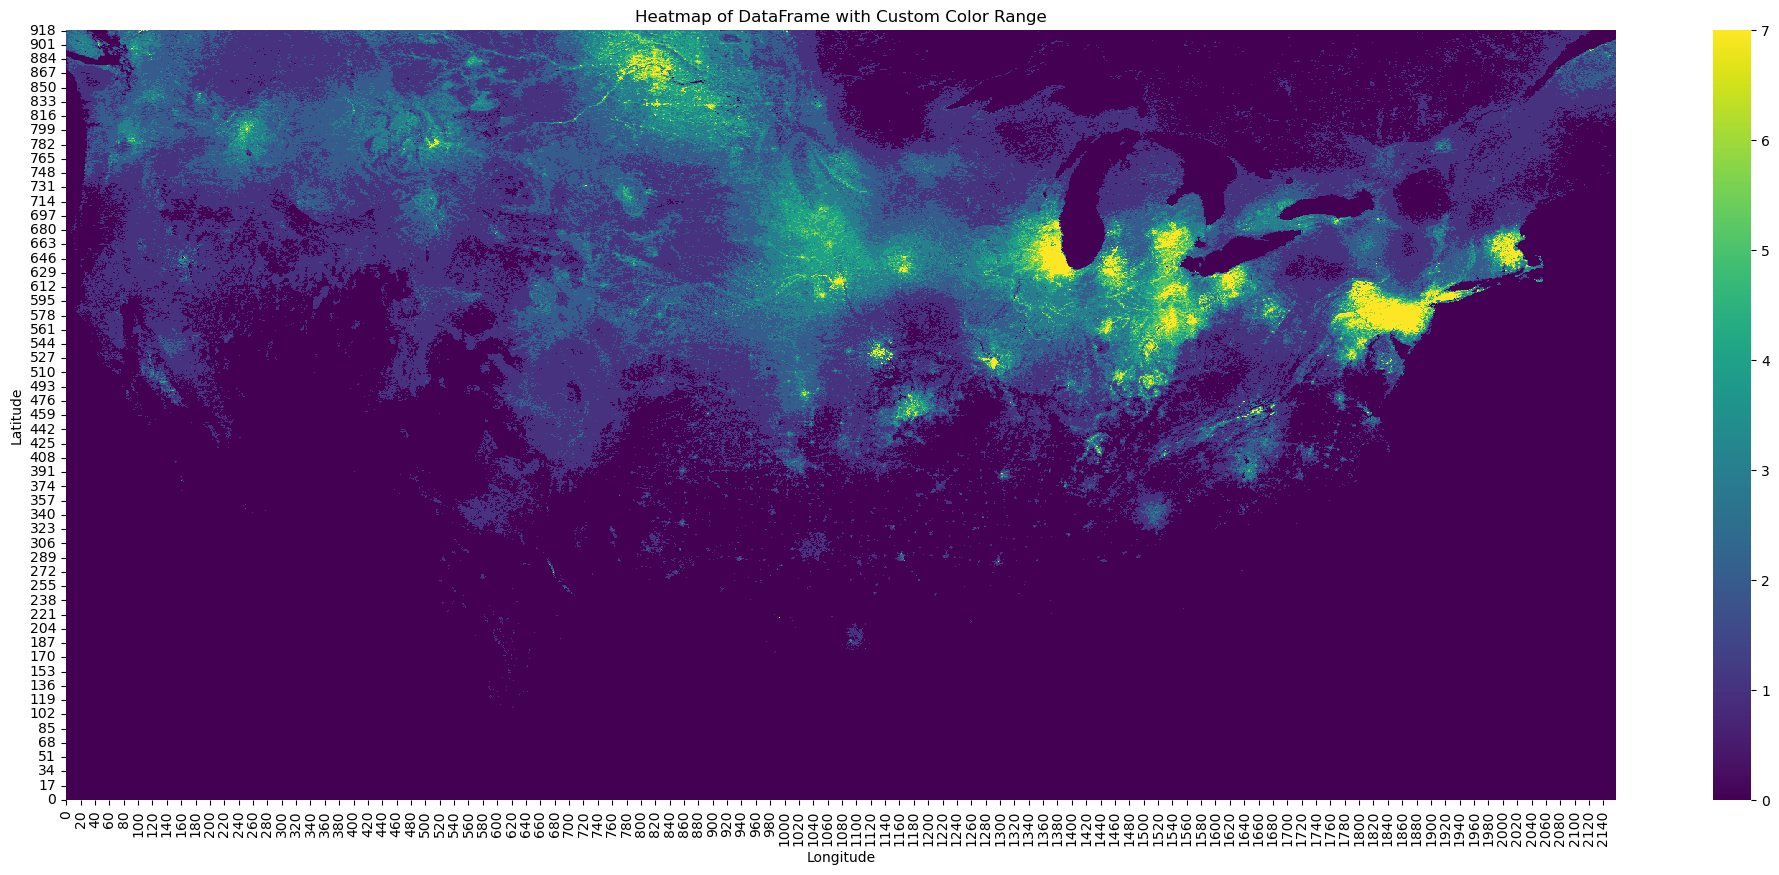

In [49]:
# Find the maximum value in the DataFrame
max_value = data.max().max()
print(f"The largest number in the data is: {max_value}")

# Reverse the order of the latitude index
data_reversed = amerob.iloc[::-1]

# Set the color range with the maximum value
plt.figure(figsize=(25, 10))
sns.heatmap(data_reversed, cmap="viridis", cbar=True, vmin=0, vmax=7)

plt.title("Heatmap of DataFrame with Custom Color Range")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


The largest number in the data is: 7


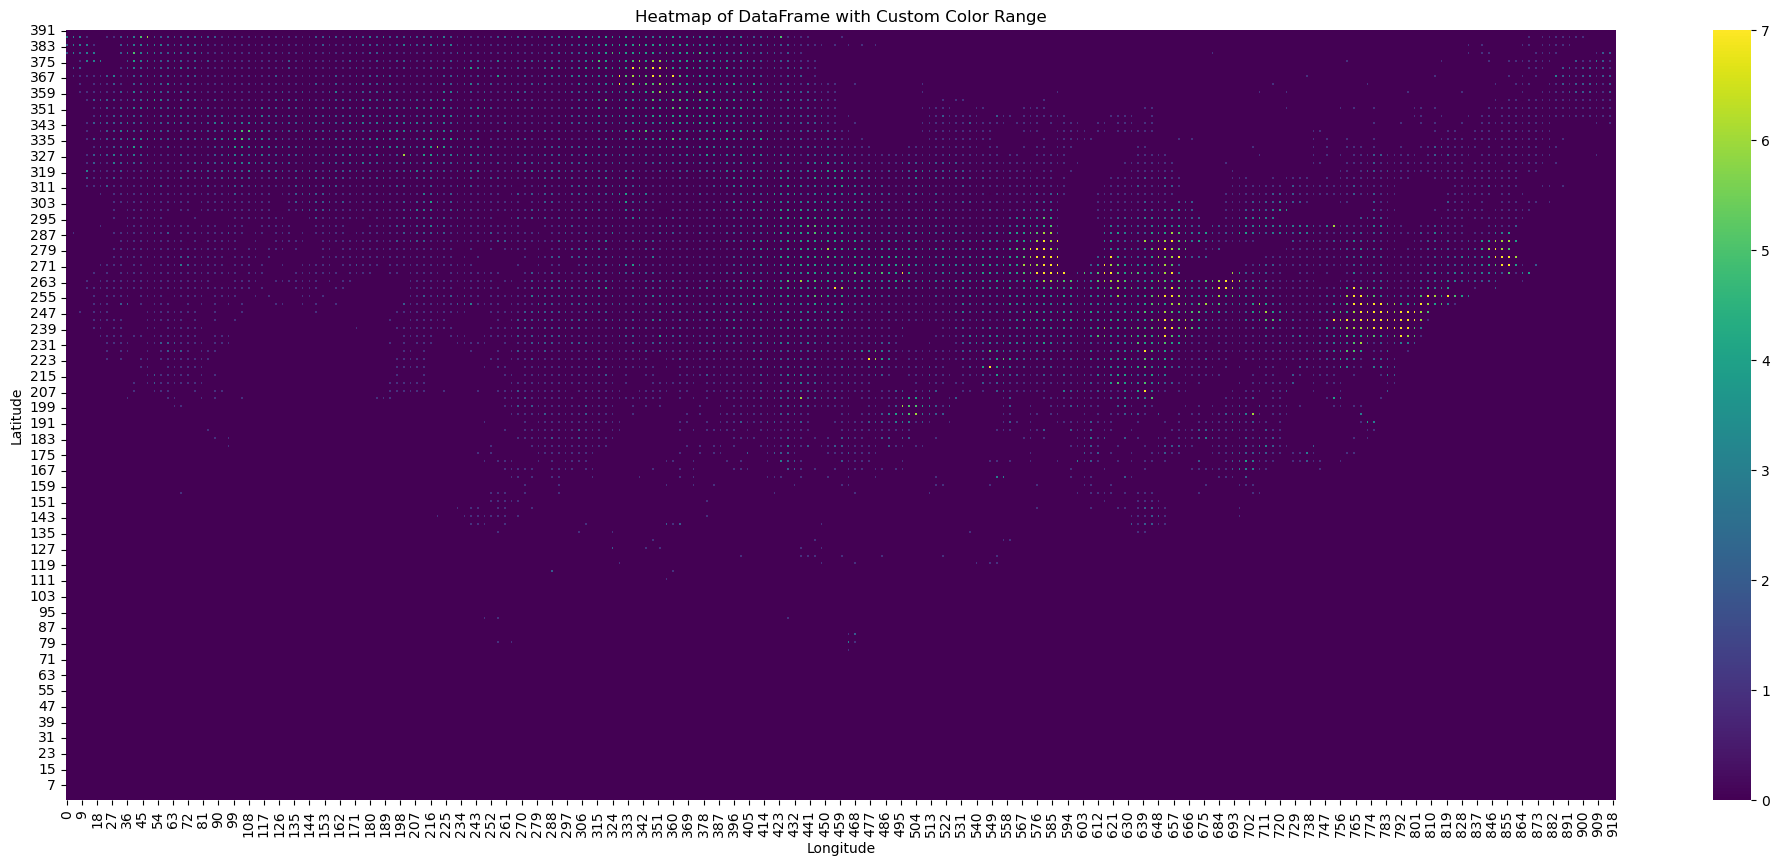

In [45]:
# Find the maximum value in the DataFrame
max_value = data.max().max()
print(f"The largest number in the data is: {max_value}")

# Reverse the order of the latitude index
data_reversed = amerob_rescaled.iloc[::-1]

# Set the color range with the maximum value
plt.figure(figsize=(25, 10))
sns.heatmap(data_reversed, cmap="viridis", cbar=True, vmin=0, vmax=7)

plt.title("Heatmap of DataFrame with Custom Color Range")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [177]:
amerob.sum().sum()

1349546

In [46]:
amerob_rescaled.sum().sum()

15296